In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
%matplotlib inline
from matplotlib import pyplot as plt
from dataclasses import dataclass
import numpy as np

In [2]:
# setup for GPU usage, with cuda ofc.
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print('Training on CPU!')

In [3]:
# I try to separate the hyperparameters here, this is usefull when I move to production
@dataclass
class hyperparams:
    # General
    epochs: int = 10
    batch_size: int = 32
    
    # Optimizer
    learning_rate: float = 0.01
    momentum: float = 0.5

# Also an object for monitoring the metrics
@dataclass
class metrics:
    train_loss: float
    train_accuracy: float
    
    val_loss: float
    val_accuracy: float

In [4]:
# Construct a labelmap for the EMNIST balanced set, so I have a reference of each class label to a number or letter based from the paper
label_map = {
    # not PEP8 formatted, but readable
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't',
}

In [240]:
# First, I download the dataset and make generators for it, I will use the torchvision API to load the EMNIST dataset as it comes with dataset generators included.

# Declare a transformer for the generator, transformations on the data can be done here, implemented compose to make adding transformation later on more easyer.
transformer = transforms.Compose([
    # First, fix the import rotate and flip all images to readable format
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    
    transforms.RandomAffine(25, translate=(.2, .2), scale=(.5, 1.5)),
    
    transforms.ToTensor(),])

# Define the train loader
train_loader = DataLoader(
    datasets.EMNIST('../data/',
                    split='balanced',
                    train=True,
                    download=True,
                    transform=transformer),
    batch_size=hyperparams.batch_size,
    shuffle=True)

# Define the test loader
test_loader = DataLoader(
    datasets.EMNIST('../data/',
                    split='balanced',
                    train=False,
                    download=True,
                    transform=transformer),
    batch_size=hyperparams.batch_size,
    shuffle=True)

In [241]:
# Make preparations to inspect the data
# By using an enumerator, it is possible to retrieve one batch per call made to the enumerator.
train_enumerator = enumerate(train_loader)

In [242]:
view_batch_images[0][0].size()

torch.Size([28, 28])

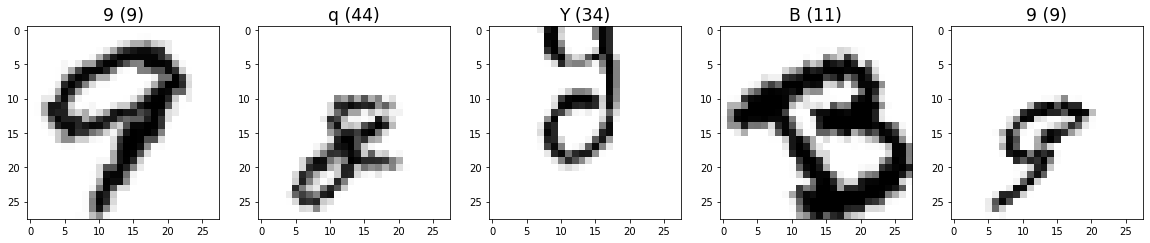

In [255]:
view_batch, (view_batch_images, view_batch_labels) = next(train_enumerator)

# Now, plot the first x images and their labels from the batch for manual evaluation
plt.figure(figsize=(20,5))
image_count = 5

for i, s in enumerate(range(image_count)):
    s = s+1
    p = plt.subplot(1, image_count, s)
    p.imshow(view_batch_images[i][0], cmap='binary')
    label = view_batch_labels[i]
    resolved = label_map[int(label)]
    p.set_title('{} ({})'.format(resolved, label), fontsize='xx-large')
plt.show()

In [15]:
class Model(nn.Module):

    # SOME MODEL NEEDS EDITING AND TUNING
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 120)  # Batch size * imdim_x * imdim_y
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 47)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

# convert the NN to cuda tensors
model.to(device)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=47, bias=True)
)

In [16]:
# lets use the CrossEntropy as loss function
loss_metric = nn.CrossEntropyLoss()

# and the SGD as optimizer for now
optimizer = optim.SGD(model.parameters(), lr=hyperparams.learning_rate , momentum=hyperparams.momentum)

In [18]:
# a list for the metrics
training_metrics = []

# training-loop
for epoch in range(hyperparams.epochs):
    
    # go over all the batches
    for i, data in enumerate(train_loader):
        # first, retrieve our data for this batch and send it to the GPU
        images = data[0].to(device)
        labels = data[1].to(device)
        
        print(images[0].size())
        
        # set the parameter gradients to zero
        optimizer.zero_grad()
        
        # Make predictions based on the training set
        outputs = model(images)
        
        # compute the loss based on model output and real labels
        loss = loss_metric(outputs, labels)
        
        # backpropagation
        loss.backward()
        
        # Optimize parameters
        optimizer.step()
        
        # loss stats per every 1000 training images
        if i % 3000 == 2999:
            val_losses = []
            
            # put network in eval mode
            model.eval()
            for val_data in test_loader:
                images = val_data[0].to(device)
                labels = val_data[1].to(device)

                output = model(images)
                val_loss = loss_metric(output, labels)

                val_losses.append(val_loss.item())
            
            # back to training
            model.train()
            # stolen from exercises
            print("Epoch: {}/{}...".format(epoch+1, hyperparams.epochs),
                  "Step: {}...".format(i),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 2

KeyboardInterrupt: 

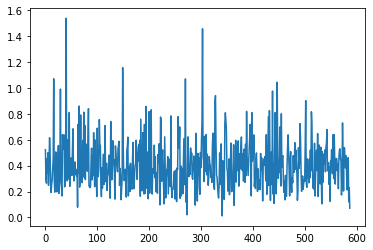

In [23]:
plt.plot(val_losses)

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [21]:
#prepare to count predictions for each class
correct_pred = {label_map[key]: 0 for key in label_map}
total_pred = {label_map[key]: 0 for key in label_map}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label_map[int(label)]] += 1
            total_pred[label_map[int(label)]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class 0     is: 71.5 %
Accuracy for class 1     is: 63.5 %
Accuracy for class 2     is: 76.8 %
Accuracy for class 3     is: 96.8 %
Accuracy for class 4     is: 90.5 %
Accuracy for class 5     is: 91.8 %
Accuracy for class 6     is: 95.0 %
Accuracy for class 7     is: 96.0 %
Accuracy for class 8     is: 89.0 %
Accuracy for class 9     is: 90.2 %
Accuracy for class A     is: 95.8 %
Accuracy for class B     is: 93.2 %
Accuracy for class C     is: 94.0 %
Accuracy for class D     is: 88.2 %
Accuracy for class E     is: 96.8 %
Accuracy for class F     is: 69.8 %
Accuracy for class G     is: 91.2 %
Accuracy for class H     is: 96.8 %
Accuracy for class I     is: 63.8 %
Accuracy for class J     is: 94.0 %
Accuracy for class K     is: 94.0 %
Accuracy for class L     is: 49.0 %
Accuracy for class M     is: 92.8 %
Accuracy for class N     is: 95.0 %
Accuracy for class O     is: 60.0 %
Accuracy for class P     is: 93.5 %
Accuracy for class Q     is: 89.8 %
Accuracy for class R     is: